In [118]:
import os
import sys

# Set working directory
plant_clef_root = '/home/ffw/workspace/plantCLEF/'
os.chdir(plant_clef_root)

data_dir = os.path.join(plant_clef_root, 'data')
print data_dir
import numpy as np
import sklearn
import scipy
import scipy.misc
import time
import logging
import tempfile
import pprint

import matplotlib.pyplot as plt
%matplotlib inline

from utilities import *
import mcl

import caffe
from caffe.proto import caffe_pb2

from caffe import layers as L
from caffe import params as P
caffe.set_mode_gpu()

import mcl.solvers as mcl_solvers
import mcl.nets.scatnet_net
reload(mcl.nets.scatnet_net)
from mcl.nets.scatnet_net import scatnet, gen_prototxt, get_layers_sizes

/home/ffw/workspace/plantCLEF/data


In [312]:


weight_param = dict(lr_mult=1, decay_mult=1)
bias_param = dict(lr_mult=2, decay_mult=0)
learned_param = [weight_param, bias_param]
frozen_param = [dict(lr_mult=0)] * 2


def fc_relu(bottom, nout, param=learned_param,
            weight_filler=dict(type='gaussian', std=0.005).copy(),
            bias_filler=dict(type='constant', value=0.1).copy()):
    fc = L.InnerProduct(bottom, num_output=nout, param=param,
                        weight_filler=weight_filler,
                        bias_filler=bias_filler)
    return fc, L.ReLU(fc, in_place=True)



def my_net(data, label=None, train=True, num_classes=10,
             classifier_name='fc8', learn_all=False, output_path = None):
    n = caffe.NetSpec()
    n.data = data
    n.label = label
    
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.fc1 =   L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
#    n.fc1 =   L.InnerProduct(n.data, num_output=500, weight_filler=dict(type='xavier'))
#    n.fc2 =   L.InnerProduct(n.fc1, num_output=500, weight_filler=dict(type='xavier'))

    n.relu1 = L.ReLU(n.fc1, in_place=True)
    n.score = L.InnerProduct(n.relu1, num_output=num_classes, weight_filler=dict(type='xavier'))
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    # write the net to a temporary file and return its filename
    if output_path:
        with open(output_path, 'w+') as f:
            f.write(str(n.to_proto()))
            return f.name
    else:
        with tempfile.NamedTemporaryFile(delete=False) as f:
            f.write(str(n.to_proto()))
            return f.name


In [313]:
def my_solver(train_net_path, 
              test_net_path=None, 
              base_lr=0.001, 
              snapshot_prefix=data_dir+'snapshot_'):
    s = caffe_pb2.SolverParameter()

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    if test_net_path is not None:
        s.test_net.append(test_net_path)
        s.test_interval = 1000  # Test after every 1000 training iterations.
        s.test_iter.append(100)  # Test on 100 batches each time we test.

    s.iter_size = 1

    s.max_iter = 100000  # # of times to update the net (training iterations)

    s.type = 'SGD'

    s.base_lr = base_lr

    s.lr_policy = 'inv'
    s.gamma = .0001
    s.power = 0.75
    s.stepsize = 20000
    
    s.momentum = 0.9
    s.weight_decay = 5e-4

    s.display = 100

    s.snapshot = 10000
    s.snapshot_prefix = snapshot_prefix

    s.solver_mode = caffe_pb2.SolverParameter.GPU

    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(s))
        return f.name


In [314]:
BATCH_SIZE = 64

L.Data()

data_layer, label_layer = L.Data(
    batch_size=BATCH_SIZE, 
    backend=P.Data.LMDB, 
    source='/home/ffw/workspace/plantCLEF/data/train_lmdb',
    ntop=2)


data_layer, label_layer = L.Data(
    batch_size=BATCH_SIZE, 
    backend=P.Data.LMDB, 
    transform_param=dict(scale=1./255),
    source='/home/ffw/workspace/caffe/examples/mnist/mnist_train_lmdb/',
    ntop=2)

data_layer_test, label_layer_test = L.Data(
    batch_size=BATCH_SIZE, 
    backend=P.Data.LMDB, 
    transform_param=dict(scale=1./255),
    source='/home/ffw/workspace/caffe/examples/mnist/mnist_test_lmdb/',
    ntop=2)



#train_data_path = os.path.join(plant_clef_root, 'data', 'train.txt')
#transform_param = dict(mirror=False, crop_size=227)
#data_layer, label_layer = L.ImageData(transform_param=transform_param,
#                                          source=train_data_path,
#                                          batch_size=BATCH_SIZE,
#                                          new_height=256,
#                                          new_width=256,
#                                          ntop=2)
#


In [328]:
proto_file = my_net(data_layer, 
                    label_layer, 
                    classifier_name='scratch', 
                    num_classes=10, 
                    train=True)

proto_file_test = my_net(data_layer_test, 
                    label_layer_test, 
                    classifier_name='scratch', 
                    num_classes=10, 
                    train=False)


solver_proto = my_solver(proto_file, proto_file_test, base_lr=0.01)

In [329]:
!cat $solver_proto

train_net: "/tmp/tmp81_UEI"
test_net: "/tmp/tmpHg3iW5"
test_iter: 100
test_interval: 1000
base_lr: 0.01
display: 100
max_iter: 100000
lr_policy: "inv"
gamma: 0.0001
power: 0.75
momentum: 0.9
weight_decay: 0.0005
stepsize: 20000
snapshot: 10000
snapshot_prefix: "/home/ffw/workspace/plantCLEF/datasnapshot_"
solver_mode: GPU
iter_size: 1
type: "SGD"


In [339]:
caffe.set_device(0)
caffe.set_mode_gpu()

solver = None
solver = caffe.SGDSolver(solver_proto)

In [331]:
solver.net.forward()  # train net
solver.test_nets[0].forward()  # test net (there can be more than one)

{'loss': array(2.390608310699463, dtype=float32)}

In [338]:
# we use a little trick to tile the first eight images
#plt.imshow(solver.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); 
#plt.axis('off')
#plt.show();
#print 'train labels:', solver.net.blobs['label'].data[:8]

#plt.imshow(solver.test_nets[0].blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); 
#plt.axis('off')
#plt.show();
#print 'test labels:', solver.test_nets[0].blobs['label'].data[:8]


In [333]:

#solver.net.forward()
solver.step(1)
#print "loss: %.4f" % (solver.net.blobs['loss'].data)
#print "acc:  %.4f" % (solver.net.blobs['acc'].data)

(-0.5, 24.5, 19.5, -0.5)

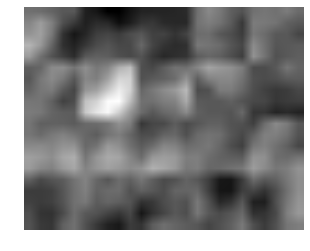

In [334]:
plt.imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5)
       .transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray'); 
plt.axis('off')




In [335]:
scores = solver.net.blobs['score'].data
actual_labels = solver.net.blobs['label'].data

In [336]:

%%time
niter = 200
test_interval = 10
# losses will also be stored in the log
train_loss = np.zeros(niter)
test_acc = np.zeros(int(np.ceil(niter / test_interval)))
output = np.zeros((niter, 8, 10))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='data')
    output[it] = solver.test_nets[0].blobs['score'].data[:8]
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
#        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4


CPU times: user 3.16 s, sys: 368 ms, total: 3.52 s
Wall time: 2.42 s


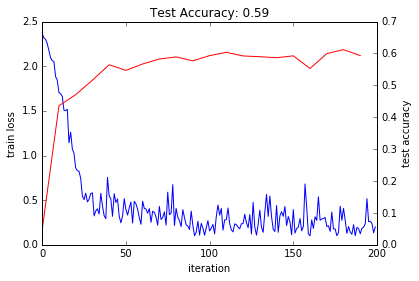

In [337]:
_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(niter), train_loss)
ax2.plot(test_interval * np.arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))

solver.iter: 2100


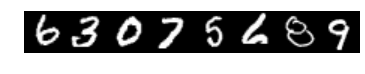

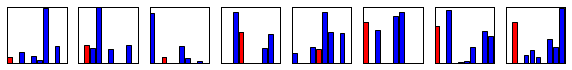

train labels: [ 6.  3.  0.  7.  5.  6.  8.  9.]
solver.iter: 2300


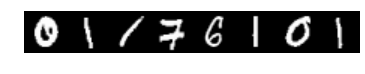

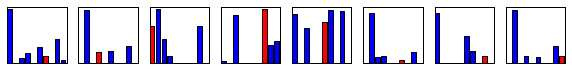

train labels: [ 0.  1.  1.  7.  6.  1.  0.  1.]
solver.iter: 2500


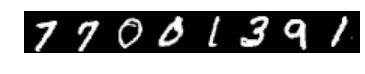

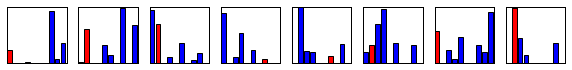

train labels: [ 7.  7.  0.  0.  1.  3.  9.  1.]


In [262]:

for _ in range(3):
#    solver.net.forward(start='conv1')
    solver.step(200)
    print "solver.iter: %i" % solver.iter
        
    plt.imshow(solver.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); 
    plt.axis('off')
    plt.show()    
#    scores = solver.net.blobs['score'].data
    scores = solver.net.blobs['score'].data[:8]
    
    w = 8
    h = 1
#    h = np.ceil(BATCH_SIZE / float(w))
    fig = plt.figure(figsize=(10,1))
    for i in range(8):
        plt.subplot(h,w,i+1)
        plt.bar(range(len(scores[i,:])), scores[i,:] * (1*scores[i,:]>0))
        plt.hold(True)
        x_actual = [actual_labels[i], actual_labels[i]]
        y_actual = [0, abs(scores[i,int(actual_labels[i])])]
        plt.bar(x_actual, y_actual, color='r')
        plt.yticks([])
        plt.xticks([])
    
    plt.show()
    
    print 'train labels:', solver.net.blobs['label'].data[:8]


In [ ]:
x_actual = [0, scores[0,int(actual_labels[0])]]
y_actual = [actual_labels[0], actual_labels[0]]

In [132]:
[actual_labels[0], actual_labels[0]], 

[185.0, 185.0]

In [177]:
len(scores[i,:])

1000